In [1]:
import pandas as pd
import numpy as np
import random
import datetime
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
from matplotlib.pyplot import figure
import matplotlib.dates as mdates
%matplotlib inline
import seaborn as sns
from tabulate import tabulate

from tsfresh.feature_extraction import extract_features
from sklearn.cluster import KMeans

np.set_printoptions(precision=4,suppress=True)
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

#code=utf-8

In [8]:
def read_data():

    sale = pd.read_json('../data/all/all_sales_clean.json', orient='split')
    sale.date = pd.to_datetime(sale.date, format = '%Y-%m-%d')
    sale.sort_values(by = 'date', inplace = True, ascending = True)
    
    product_list = pd.read_csv('../data/product.csv', index_col = 0,encoding='ISO-8859-1')
    product_list = product_list['product_name']
    sales = sale.merge(product_list, how = 'inner', left_on = 'product_id', right_index = True)
    sales = sales.set_index(['date'])
    products = sales[['product_id','product_name']].set_index('product_id').product_name.to_dict()
    product_ids = sales.product_id.drop_duplicates().tolist()

    return sales, products, product_ids

In [3]:
# function to plot qty for one product
def plot_qty(df, product_id, name):
    fig, ax = plt.subplots(figsize=(15,4))
    ax.plot(df[product_id].qty)
    ax.set_title('Qty of %d - %s' % (product_id, name[product_id]))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval = 7))
    fig.autofmt_xdate()
    plt.show()
    return

# function to plot randomly selected products to verify the grouping result
def random_plot_qty(df, product, num, name, group):
    ncols = 2
    nrows = int(num / ncols)
    selected_product = random.sample(group.index.drop_duplicates().tolist(), num)
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(20,10))
    plt.subplots_adjust(wspace=0.1)
    for i in range(nrows):
        for j in range(ncols):
                ax[i][j].plot(df[selected_product[ncols*i+j]].qty, linewidth = 1)
                id = selected_product[ncols*i+j]
                title = str(id) + " - " + name[id] + ", group %d" % (group.loc[id, 'group'])
                ax[i][j].set_title(title)
#     fig.savefig('../data/all/segmentation/random qty plot.png', dpi = 300)
    plt.show()
    return

In [4]:
# add vendor name in features, perform one-hot-encoding  
def add_vendor(features):
    vendor = pd.read_csv('../data/all/segmentation/vendor.csv', index_col = 0)
    features = features.merge(vendor.vendor_name, how = 'left', left_index = True, right_index = True)
    features.columns = features.columns.str.strip()
    features = pd.get_dummies(features, columns = ['vendor_name'])
    return features

In [5]:
# extract relevant time series features
#   feature reference:  https://tsfresh.readthedocs.io/en/latest/text/list_of_features.html
def tsfeatures(X):
    fc_parameters = {
        "kurtosis": None, "skewness": None, "mean": None, "maximum": None, "minimum": None,"standard_deviation": None,
        "count_above_mean": None, "longest_strike_above_mean": None, 
        "autocorrelation": [{"lag": 7}, {"lag": 14},{"lag": 30}],
        "value_count": [{"value": 0}],
        "number_crossing_m": [{"m": 60}, {"m": 100}, {"m": 300},{"m": 400},{"m": 800}]}
    features = extract_features(X, column_id = 'product_id', column_sort  ='date', n_jobs=1, default_fc_parameters=fc_parameters)
    features = features.rename(columns ={'qty__autocorrelation__lag_7':'acf_lag7','qty__autocorrelation__lag_14':'acf_lag14',
                'qty__autocorrelation__lag_30':'acf_lag30', 
                'qty__count_above_mean':'count_above_mean','qty__first_location_of_maximum': 'first_date_of_max',
                'qty__kurtosis':'kurtosis','qty__skewness':'skewness','qty__longest_strike_above_mean':'longest_strike_above_mean',
                'qty__maximum':'max','qty__minimum':'min','qty__mean':'mean','qty__standard_deviation':'sd',
                'qty__value_count__value_0': 'num_zero_qty',
                'qty__number_crossing_m__m_60':'days_qty_above60',
                'qty__number_crossing_m__m_100':'days_qty_above100', 'qty__number_crossing_m__m_300':'days_qty_above300', 
                'qty__number_crossing_m__m_400':'days_qty_above400', 'qty__number_crossing_m__m_800':'days_qty_above800'})
    return features

In [6]:
# perform kmean clustering on product segmentation
def kmeans_clustering(features):
    kmeans = KMeans(n_clusters=4, random_state=100).fit(features)
    ids = features.index.tolist()
    labels = kmeans.labels_
    group_result = {}
    for i in range(len(ids)):
        group_result[ids[i]] = labels[i]        
    return group_result

In [30]:
# read data
# data, products, product_ids = read_data()
# sales = {}
# for Id in product_ids:
#     sales[Id] = data[data.product_id == Id]

# extract time series features
# X = data[['product_id','qty']].reset_index(drop = False)
# features = tsfeatures(X)

# features_vendor = add_vendor(features)
# features_vendor = features.fillna(0)

# perform clustering
# group_result = kmeans_clustering(features_vendor)

# save segmentation results as csv
# group = pd.DataFrame.from_dict(group_result, orient = 'index', columns = ['group'] )
# group.to_csv('../data/all/segmentation/product_segmentation.csv')
group = pd.read_csv('../data/all/segmentation/product_segmentation.csv', index_col=0)

In [42]:
print(group.groupby(['group']).size())

group
0    6809
1    3077
2    1383
3     195
dtype: int64


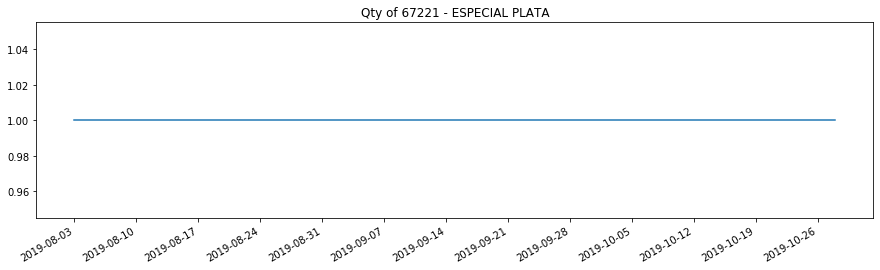

In [34]:
plot_qty(sales, 12382, products)

In [35]:
print(len(sales[19041]))

244


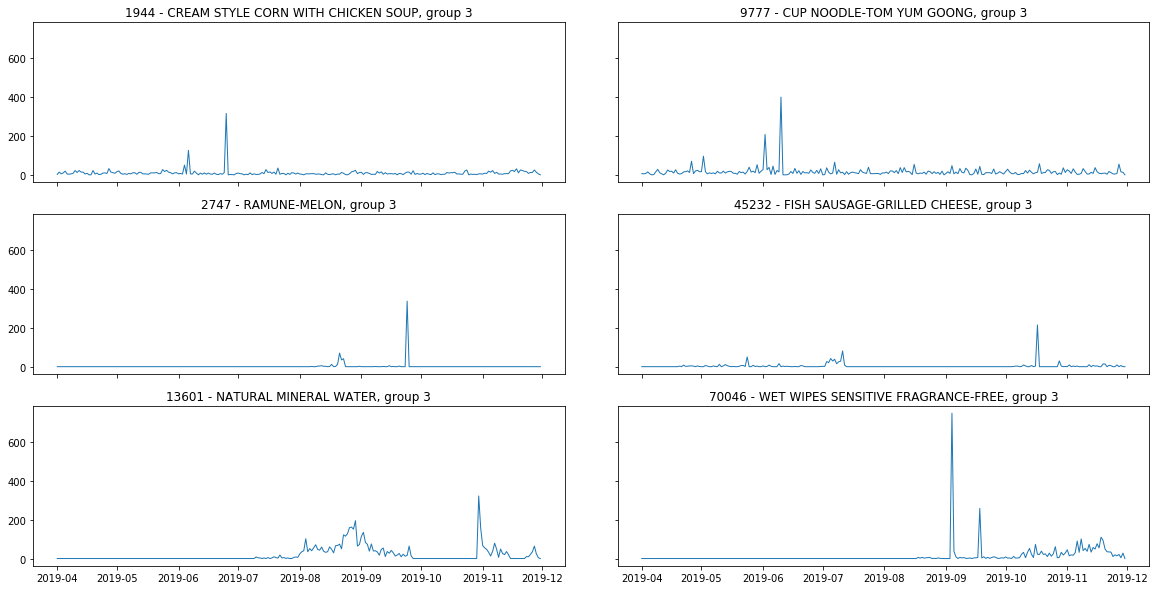

In [46]:
random_plot_qty(sales, product_ids, 6, products, group[group.group==3])